In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import deque
import random

import gymnasium as gym

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# DQN agent with soft target network and replay buffer

In [29]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

    
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)
    
    
class QNetworkBN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetworkBN, self).__init__()
        # Define layers individually
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, output_dim)

    def forward(self, x):
        # Check batch size
        batch_size_one = x.size(0) == 1

        x = F.relu(self.bn1(self.fc1(x)) if not batch_size_one else self.fc1(x))
        x = F.relu(self.bn2(self.fc2(x)) if not batch_size_one else self.fc2(x))
        x = F.relu(self.bn3(self.fc3(x)) if not batch_size_one else self.fc3(x))
        x = F.relu(self.bn4(self.fc4(x)) if not batch_size_one else self.fc4(x))
        x = self.fc5(x)

        return x
    
    
class QNetworkLN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetworkLN, self).__init__()
        # Define layers with Layer Normalization
        self.fc1 = nn.Linear(input_dim, 64)
        self.ln1 = nn.LayerNorm(64)
        self.fc2 = nn.Linear(64, 128)
        self.ln2 = nn.LayerNorm(128)
        self.fc3 = nn.Linear(128, 128)
        self.ln3 = nn.LayerNorm(128)
        self.fc4 = nn.Linear(128, 64)
        self.ln4 = nn.LayerNorm(64)
        self.fc5 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.fc5(x)

        return x

In [30]:
class DQNAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, replay_buffer_size, batch_size, tau, device):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.memory = ReplayBuffer(replay_buffer_size)
        self.batch_size = batch_size

        # Hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau

        # Networks
        self.device = torch.device(device)
        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network = QNetwork(self.state_dim, self.action_dim)
        self.q_network = self.q_network.to(self.device)
        self.target_network = self.target_network.to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)

    def choose_action(self, state, use_epsilon=True):
        """
        Method for choosing action by an agent with q_network

        Parameters
        ----------
        state: int
            int representing state
        use_epsilon: bool
            whether to use epsilon-greedy strategy

        Returns
        -------
        action: int
            number of action
        """
        if use_epsilon and np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_values = self.q_network(state)

        max_q_value = torch.max(action_values)
        max_actions = [action for action, q_value in enumerate(action_values[0]) if q_value == max_q_value]
        action = np.random.choice(max_actions)
        return action

    def soft_update_target_network(self):
        """
        Updates weights of the target network by blending them with weights of q_network
        according to formula target_weight := tau * q_weight + (1 - tau) * target_weight
        """
        for target_param, local_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def learn(self):
        """
        Obtain minibatch of size self.batch_size from replay buffer and performs 
        backpropagation step on minibatch for q_network
        """
        if len(self.memory) < self.batch_size:
            return
        # obtain tuples from replay buffer and convert them to torch tensors
        state, action, reward, next_state, done = zip(*[(s[0] if len(s) == 2 else s, a, r, ns, d) for s, a, r, ns, d in self.memory.sample(self.batch_size)])
        # speed up convertion to torch tensor
        state = np.vstack(state)
        next_state = np.vstack(next_state)
        # convert to 
        state = torch.FloatTensor(state).to(self.device)
        action = torch.LongTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).to(self.device)
        # calculate predicted q_values with q_network for current state
        q_values = self.q_network(state).gather(1, action.unsqueeze(1)).squeeze(1)
        # obtain "actual" q_values with target network
        next_q_values = self.target_network(next_state).max(1)[0]
        # calculate expected q_values
        expected_q_values = reward + self.gamma * next_q_values * (1 - done)
        # backpropagation for q_network
        loss = nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, n_episodes=1000, verbose=True):
        """
        Trains deep q agent with soft target network
        
        Parameters
        ----------
        n_episodes: int
            number of episodes to run for training
        verbose: bool
            if True, average reward for last 100 episodes is printed

        Returns
        -------
        rewards: list
            list of total accumulated rewards for each episode
        """
        rewards = []
        for episode in tqdm(range(n_episodes)):
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                state = state[0] if len(state) == 2 else state
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.memory.push(state, action, reward, next_state, done)
                self.learn()
                self.soft_update_target_network()
                state = next_state
                total_reward += reward

            rewards.append(total_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            
            if verbose and (episode + 1) % 100 == 0:
                print(f"Episode: {episode + 1}, Average Reward: {np.mean(rewards[-100:])}")

        if verbose:
            print("Training completed")
        return rewards
    
    
    def exploit(self, env, n_episodes=100, verbose=True):
        """
        Method for evaluating the agent using pure exploitation

        Parameters
        ----------
        env: gymnasium environment
            the environment to interact with
        n_episodes: int
            number of episodes to run for evaluation
        verbose: bool
            if True, average reward for last 100 episodes is printed

        Returns
        -------
        rewards: list
            list of total accumulated rewards for each episode
        """
        rewards = []
        for episode in tqdm(range(n_episodes)):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                state = state[0] if len(state) == 2 else state
                action = self.choose_action(state, use_epsilon=False)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                total_reward += reward

            rewards.append(total_reward)

            if verbose and (episode + 1) % 100 == 0:
                print(f"Episode: {episode + 1}, Average Reward: {np.mean(rewards[-100:])}")
        env.close() 
        return rewards



In [31]:
def set_seed(seed, env=None):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    if env is not None:
        env.seed(seed)

# Training and exploitation

In [35]:
env = gym.make('LunarLander-v2')
set_seed(seed=42, env=None)
agent = DQNAgent(
    env=env, 
    alpha=1e-4,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    replay_buffer_size=10000,
    batch_size=128,
    tau=0.005,
    device="cpu"
)

In [36]:
training_rewards = agent.train(n_episodes=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Episode: 100, Average Reward: -141.1755820772751
Episode: 200, Average Reward: -51.05044256573637
Episode: 300, Average Reward: 59.785449439157155
Episode: 400, Average Reward: 180.96644849927569
Episode: 500, Average Reward: 196.3467355270105
Episode: 600, Average Reward: 241.07213544652868
Episode: 700, Average Reward: 251.03383771958678
Episode: 800, Average Reward: 252.455392112984
Episode: 900, Average Reward: 262.5992660273413
Episode: 1000, Average Reward: 260.9371655928634
Episode: 1100, Average Reward: 270.3472513296503
Episode: 1200, Average Reward: 272.0379527983092
Episode: 1300, Average Reward: 277.0083909486627
Episode: 1400, Average Reward: 278.27354955920663
Episode: 1500, Average Reward: 272.85007544612495
Episode: 1600, Average Reward: 246.59816732129744
Episode: 1700, Average Reward: 263.42968558392744
Episode: 1800, Average Reward: 255.50476231143983
Episode: 1900, Average Reward: 264.8332878784959
Episode: 2000, Average Reward: 216.42366577460953
Episode: 2100, Ave

In [37]:
exploitation_rewards = agent.exploit(env, n_episodes=3000, verbose=False)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [44]:
env_render = gym.make('LunarLander-v2', render_mode='human')
tmp = agent.exploit(env_render, n_episodes=10)

  0%|          | 0/10 [00:00<?, ?it/s]

# Visualization

In [38]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def plot_rewards(rewards, title):
    ma_rewards = moving_average(rewards)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

    ax[0].plot(rewards)
    ax[1].plot(np.arange(len(ma_rewards)) + 100, ma_rewards)

    ax[0].grid()
    ax[1].grid()

    ax[0].set_title("Total rewards for an episode")
    ax[1].set_title("Rolling average reward for 100 previous episodes")

    fig.suptitle(f"{title}")
    plt.show()

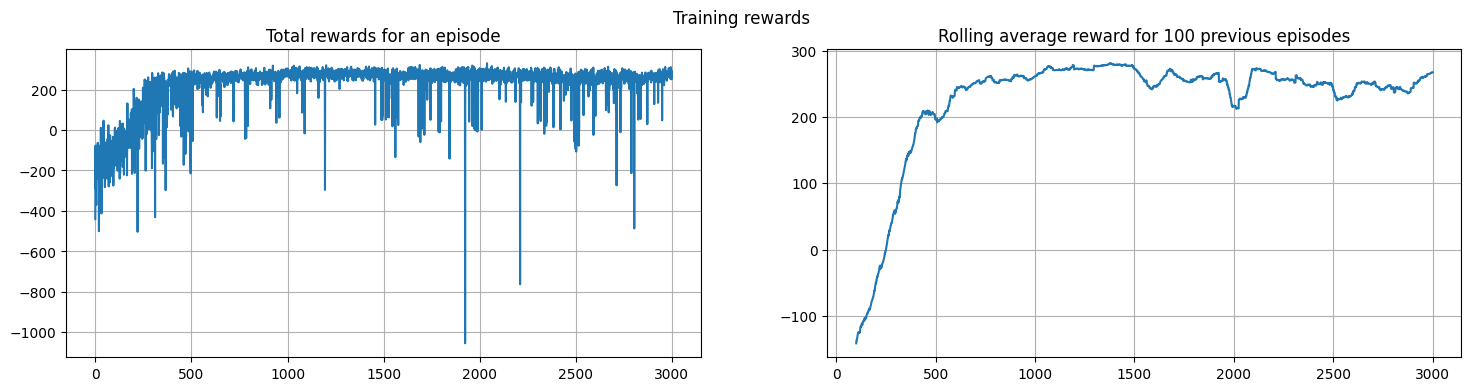

In [39]:
plot_rewards(training_rewards, "Training rewards")

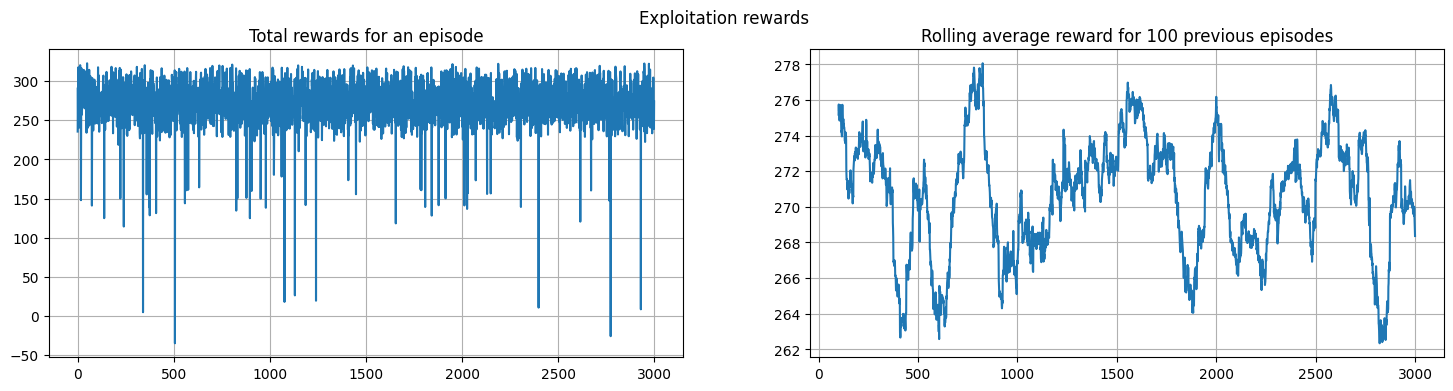

In [40]:
plot_rewards(exploitation_rewards, "Exploitation rewards")